## Using Code Interpreter with Responses API

### Environment Setup

In [1]:
# Import required packages
import os
import json
import requests
from pathlib import Path
from IPython.display import Image, display
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

In [2]:
# Set up environment variables for Azure OpenAI
AOAI_API_BASE = os.getenv("AZURE_OPENAI_API_BASE")
AOAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
AOAI_DEPLOYMENT = os.getenv("AZURE_OPENAI_API_DEPLOY")

### Azure OpenAI Client Setup

In [3]:
# Initialise token provider
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(),
    "https://cognitiveservices.azure.com/.default"
)

In [4]:
# Initialise Azure OpenAI client
client = AzureOpenAI(  
    azure_endpoint = AOAI_API_BASE,
    azure_ad_token_provider = token_provider,
    api_version = AOAI_API_VERSION,
)

### Testing Responses API

In [5]:
# Test Responses API
response = client.responses.create(
    model = AOAI_DEPLOYMENT,
    input = "Generate a haiku about the sea", 
)

print(response.output[0].content[0].text) 

Endless waves embrace,  
Whispers dance on salt-kissed breeze,  
Ocean’s heart beats deep.


### Code Interpreter output

In [6]:
# Set input prompt
INPUT_TEXT = "Could you please analyse the operating profit of Contoso Inc. using the following data and producing a bar chart image. Contoso Inc. Operating Profit: Quarter 1: $2.2 million, Quarter 2: $2.5 million, Quarter 3: $2.3 million, Quarter 4: $3.8 million, Industry Average: $2.5 million. When quarter values in 2025 fall below the industry average, please highlight them in red, otherwise they should be green."

In [7]:
# Generate a file with the code interpreter
response = client.responses.create(
    model = AOAI_DEPLOYMENT,
    tools = [
        {
            "type": "code_interpreter",
            "container": {"type": "auto"}
        }
    ],
    instructions = "You are a helpful data analyst. You should use Python tool to perform required calculations.",
    input = INPUT_TEXT
)

# print(response.model_dump_json(indent=2))

In [8]:
# Extract details of generated files
extracted_files = []

for item in response.output:
    if hasattr(item, 'content'):
        for content_block in item.content:
            if hasattr(content_block, 'annotations') and content_block.annotations:
                for annotation in content_block.annotations:
                    if hasattr(annotation, 'file_id'):
                        file_info = {
                            "container_id": getattr(annotation, 'container_id', None),
                            "file_id": getattr(annotation, 'file_id', None),
                            "filename": getattr(annotation, 'filename', None)
                        }
                        extracted_files.append(file_info)

print(json.dumps(extracted_files, indent=2))

[
  {
    "container_id": "cntr_689df3cb69648190b73217f54eeb713806df641648828556",
    "file_id": "cfile_689df41900fc81909d22ec83e7dafbe1",
    "filename": "cfile_689df41900fc81909d22ec83e7dafbe1.png"
  }
]


In [9]:
# Download generated files
if extracted_files:
    token = token_provider()
    headers = {"Authorization": f"Bearer {token}"}
    params = {"api-version": "preview"}

    for file in extracted_files:
        container_id = file['container_id']
        file_id = file['file_id']
        filename = file['filename']
        url = f"{AOAI_API_BASE}openai/v1/containers/{container_id}/files/{file_id}/content"

        try:        
            response_req = requests.get(url, headers=headers, params=params, timeout=30)
            if response_req.status_code == 200:
                Path("./downloads").mkdir(exist_ok=True)
                file_path = Path("./downloads") / filename
            
                with open(file_path, 'wb') as f:
                    f.write(response_req.content)

                print(f"Successfully downloaded to {file_path}")
            else:
                print(f"Failed to download container file {filename}, status code: {response_req.status_code}")
        except Exception as e:
            print(f"Exception: {str(e)}")

else:
    print("No files extracted from the Response API.")


Successfully downloaded to downloads\cfile_689df41900fc81909d22ec83e7dafbe1.png


### Verifying Graphical Output

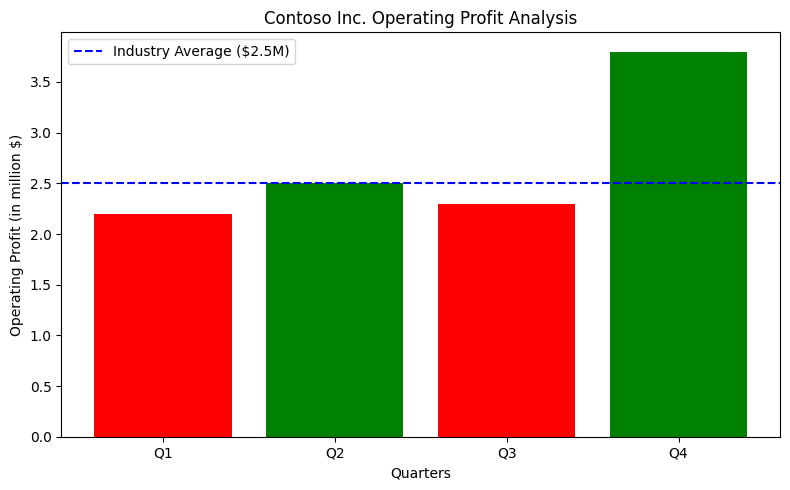

In [10]:
# Display downloaded files
if extracted_files:
    
    for file in extracted_files:
        filename = file['filename']
        if filename.endswith('.png'):
            file_path = Path("./downloads") / filename
            if file_path.exists():
                display(Image(filename=file_path))
            else:
                print(f"File not found: {file_path}")